In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from livelossplot import PlotLossesKeras
from src import camvid
from src import segnet
from src.utils import history_to_results
from src.utils import heatmap
from src.wrappers import MonteCarlo
%matplotlib inline
plt.style.use('dark_background')

Using TensorFlow backend.
/usr/local/anaconda5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
!mkdir -p models
weights_file = 'models/BayesianSegNet-CamVid11.h5'

In [3]:
mapping = pd.read_table('11_class.txt', sep=r'\s+', names=['og', 'new'], index_col='og')['new'].to_dict()
mapping

{'Animal': 'Pedestrian',
 'Archway': 'Building',
 'Bicyclist': 'Bicyclist',
 'Bridge': 'Building',
 'Building': 'Building',
 'Car': 'Car',
 'CartLuggagePram': 'Car',
 'Child': 'Pedestrian',
 'Column_Pole': 'Column_Pole',
 'Fence': 'Fence',
 'LaneMkgsDriv': 'Road',
 'LaneMkgsNonDriv': 'Road',
 'Misc_Text': 'SignSymbol',
 'MotorcycleScooter': 'Car',
 'OtherMoving': 'Car',
 'ParkingBlock': 'Sidewalk',
 'Pedestrian': 'Pedestrian',
 'Road': 'Road',
 'RoadShoulder': 'Road',
 'SUVPickupTruck': 'Car',
 'Sidewalk': 'Sidewalk',
 'SignSymbol': 'SignSymbol',
 'Sky': 'Sky',
 'TrafficCone': 'Building',
 'TrafficLight': 'Building',
 'Train': 'Car',
 'Tree': 'Tree',
 'Truck_Bus': 'Car',
 'Tunnel': 'Building',
 'VegetationMisc': 'Tree',
 'Void': 'Road',
 'Wall': 'Building'}

In [4]:
batch_size = 8
# the size to reshape images to before transformation
target_size = (360, 480)
# the size to crop images to
crop_size = (352, 480)

In [5]:
# all crop dimensions must be divisible by this value due 
# to the requirement of equal shapes between downsampling 
# outputs and upsampling inputs imposed by the concatenation
# in skip link connections
divisible_by = int(2**5)
# iterate over all the crop dimensions
for dim in crop_size:
    # raise error if the dimension has a remainder when divided
    if dim % divisible_by:
        f = 'crop dimension ({}) must be divisible by {}'
        f = f.format(dim, divisible_by)
        raise ValueError(f)

# Training

In [6]:
camvid11 = camvid.CamVid(mapping=mapping, target_size=target_size, crop_size=crop_size, batch_size=batch_size)
generators = camvid11.generators()

Found 367 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 233 images belonging to 1 classes.
Found 233 images belonging to 1 classes.


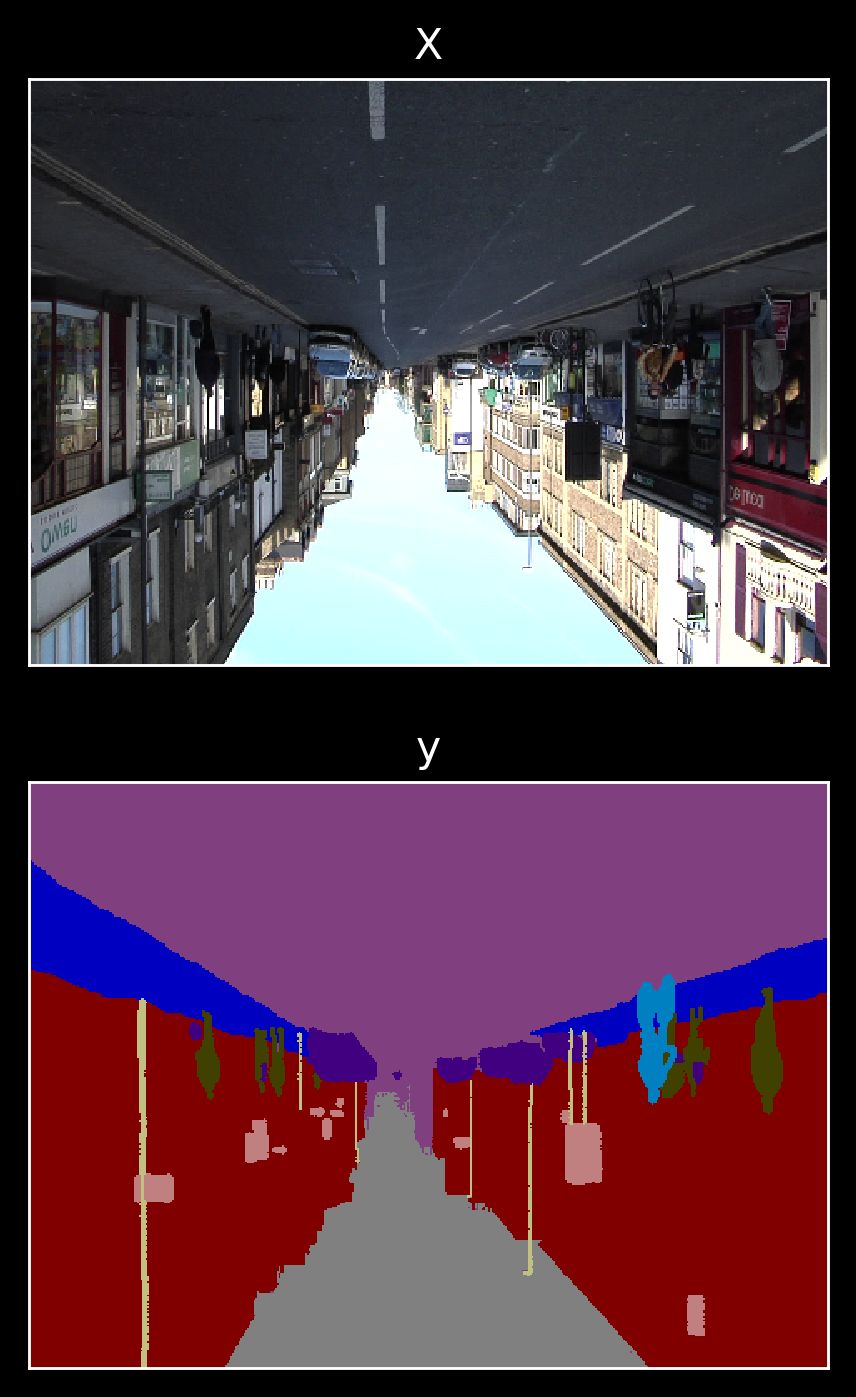

In [7]:
# get the next X, y training tuple
X, y = next(generators['train'])
# transform the onehot vector to an image
y = camvid11.unmap(y)
# plot the images
camvid.plot(X=X[0], y=y[0])

In [8]:
# build the model for the image shape and number of labels
model = segnet.build_segnet((*crop_size, 3), camvid11.n, 
    label_names=camvid11.discrete_to_label_map,
    class_weights=camvid11.class_weights,
    dropout_rate=0.5,
)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SegNet_input (InputLayer)    (None, 352, 480, 3)       0         
_________________________________________________________________
pixel_norm (Lambda)          (None, 352, 480, 3)       0         
_________________________________________________________________
lcn (ContrastNormalization)  (None, 352, 480, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 352, 480, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 352, 480, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 352, 480, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 352, 480, 64)      36928     
__________

In [9]:
# create the callbacks for the training procedure
callbacks = [
    PlotLossesKeras(),
    EarlyStopping(monitor='loss', patience=10),
    ModelCheckpoint(weights_file, 
        monitor='loss', 
        save_best_only=True, 
        save_weights_only=True, 
        mode='min'
    ),
    LearningRateScheduler(lambda _, lr: 0.95 * lr),
]

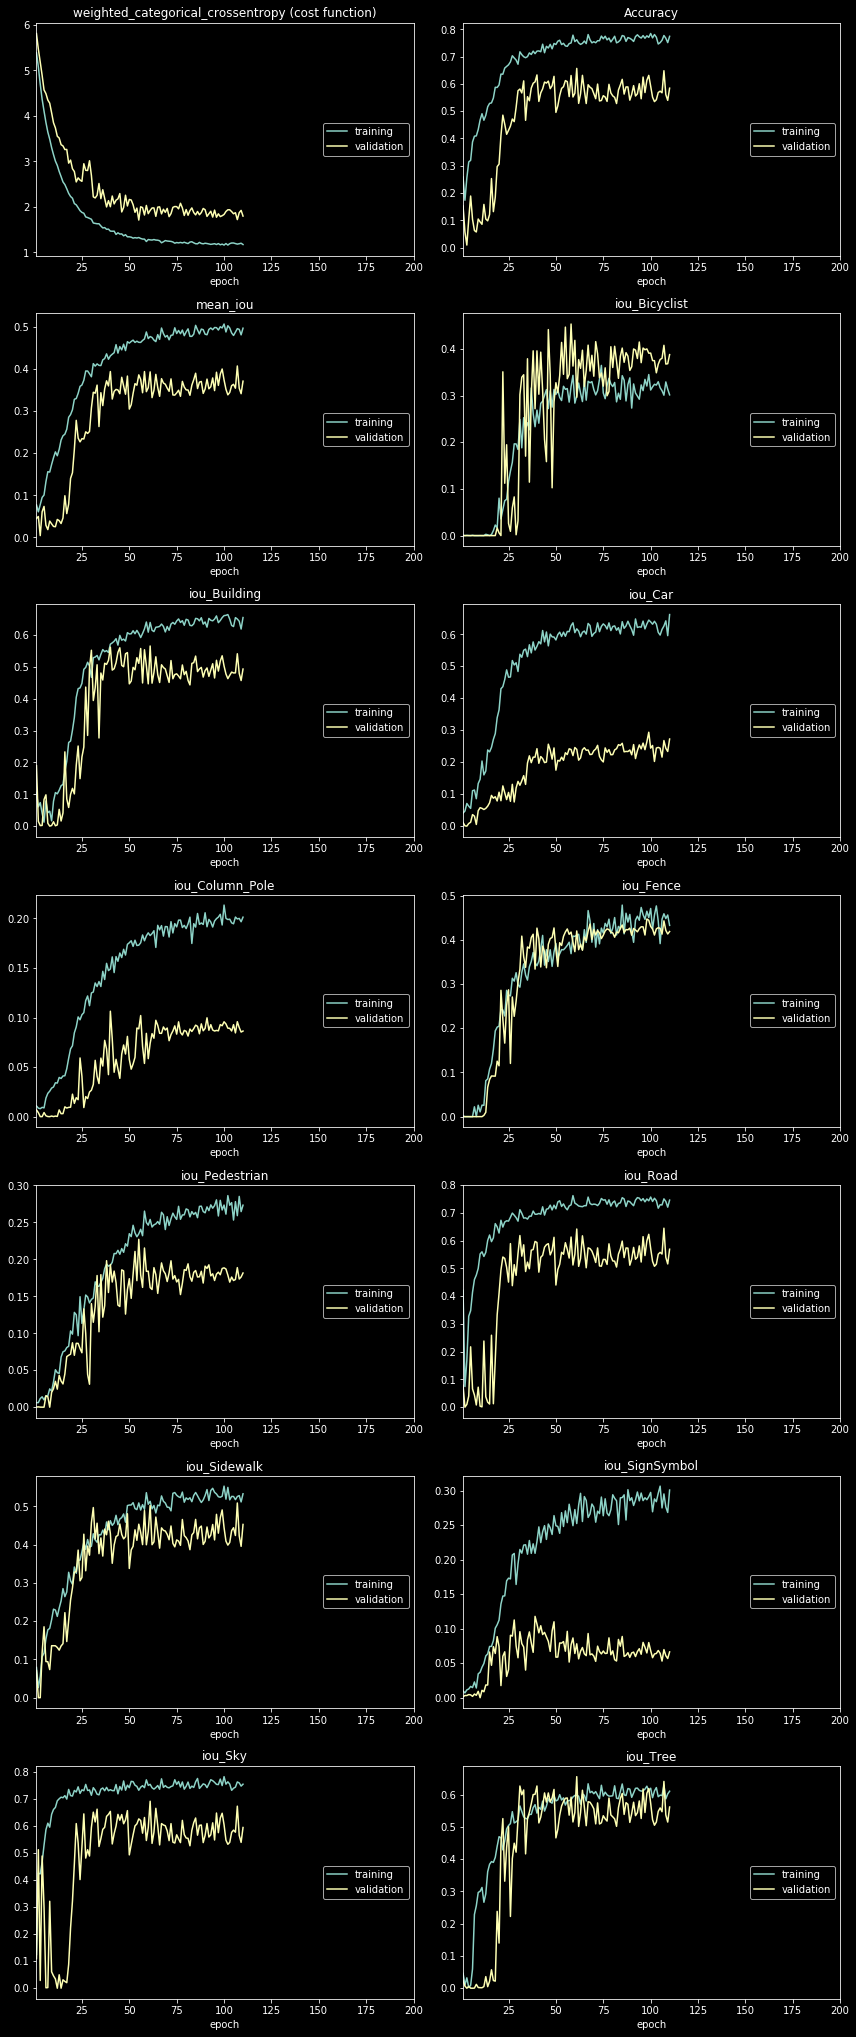

In [10]:
# fit the model with the data. divide the steps per epoch by the 
# batch size (which is 3 in this case)
history = model.fit_generator(generators['train'],
    epochs=200,
    steps_per_epoch=int(367 / batch_size),
    validation_data=generators['val'],
    validation_steps=101,
    callbacks=callbacks,
    verbose=0
)

In [11]:
history_to_results(history)

train       val
acc          0.774638  0.584402
Bicyclist    0.301444  0.387640
Building     0.655103  0.493407
Car          0.661526  0.272345
Column_Pole  0.201285  0.086402
Fence        0.432529  0.418581
Pedestrian   0.273256  0.181473
Road         0.745415  0.568677
Sidewalk     0.533158  0.453012
SignSymbol   0.300743  0.066338
Sky          0.755168  0.594826
Tree         0.610392  0.561455
loss         1.173802  1.799258
mean_iou     0.497274  0.371287

## Load Best Model

In [12]:
model.load_weights(weights_file)

# Test Metrics

In [13]:
# wrap the model with the test time Monte Carlo
model = MonteCarlo(model, 50)

In [14]:
metrics = model.evaluate_generator(generators['test'], steps=233)
names = model.metrics_names
pd.DataFrame(metrics, names, columns=['val'])

100%|██████████| 50/50 [31:10<00:00, 37.40s/simulation]


val
loss             1.251596
acc              0.799164
mean_iou         0.406959
iou_Bicyclist    0.064907
iou_Building     0.555856
iou_Car          0.420573
iou_Column_Pole  0.171410
iou_Fence        0.123636
iou_Pedestrian   0.183474
iou_Road         0.798016
iou_Sidewalk     0.664402
iou_SignSymbol   0.113596
iou_Sky          0.851671
iou_Tree         0.529012

# Qualitative Results

In [15]:
def predict(generator) -> tuple:
    """
    Return post-processed predictions for the given generator.

    Args:
        generator: the generator to get data from

    Returns:
        a tuple of for NumPy tensors with RGB data:
        - the batch of RGB X values
        - the unmapped RGB batch of y values
        - the unmapped RGB predicted mean values from the model
        - the meatmap RGB values of the model variance

    """
    # get the batch of data
    X, y = next(generator)
    # predict mean values and variance
    u, s2 = model.predict(X)
    # calculate the mean variance over the labels
    s2 = s2.mean(axis=-1)
    # return X values, unmapped y and u values, and heatmap of s2
    return X, camvid11.unmap(y), camvid11.unmap(u), heatmap(s2, 'Greys')

### Train Results

In [16]:
X, y, p, s = predict(generators['train'])

100%|██████████| 50/50 [00:16<00:00,  3.06simulation/s]


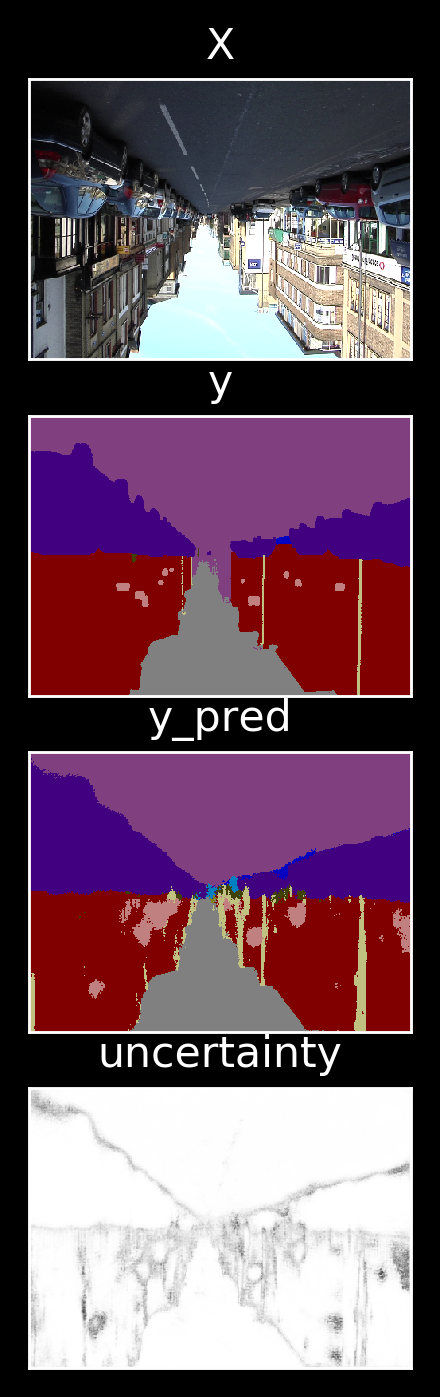

In [17]:
camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0])

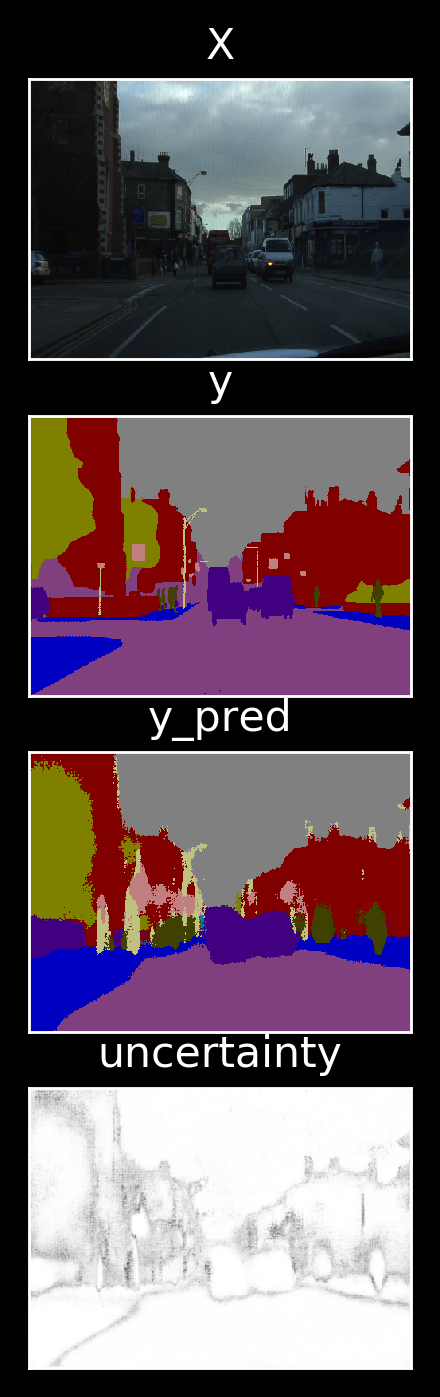

In [18]:
camvid.plot(X=X[1], y=y[1], y_pred=p[1], uncertainty=s[1])

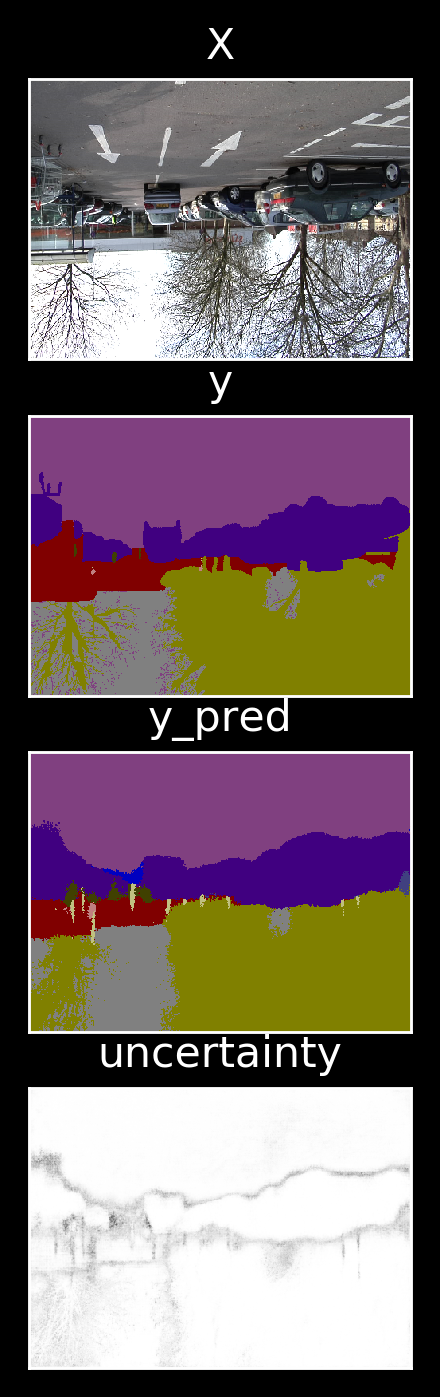

In [19]:
camvid.plot(X=X[2], y=y[2], y_pred=p[2], uncertainty=s[2])

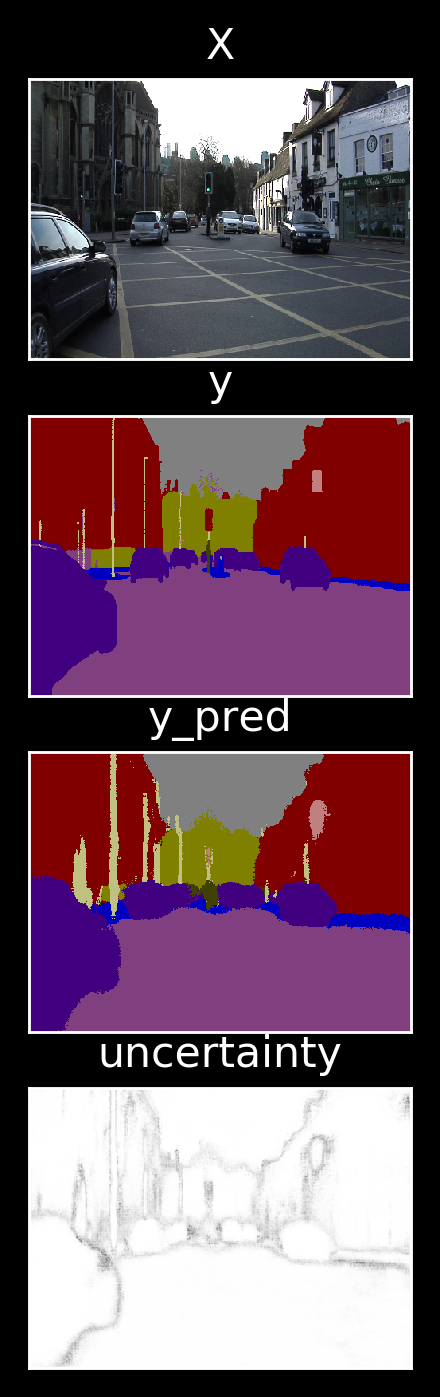

In [20]:
camvid.plot(X=X[3], y=y[3], y_pred=p[3], uncertainty=s[3])

### Validation Results

100%|██████████| 50/50 [00:02<00:00, 17.94simulation/s]


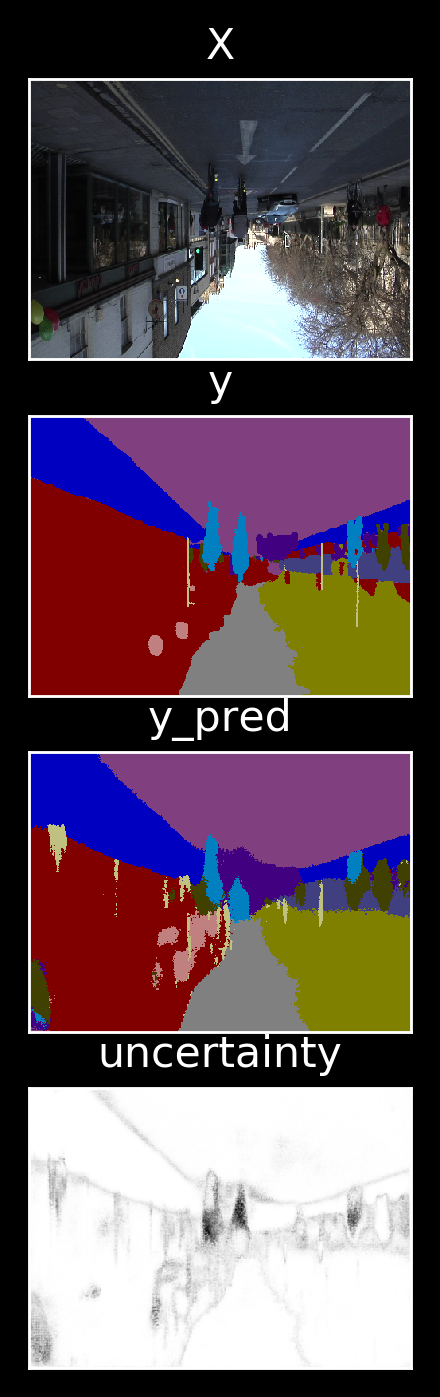

In [21]:
X, y, p, s = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0])

100%|██████████| 50/50 [00:02<00:00, 18.13simulation/s]


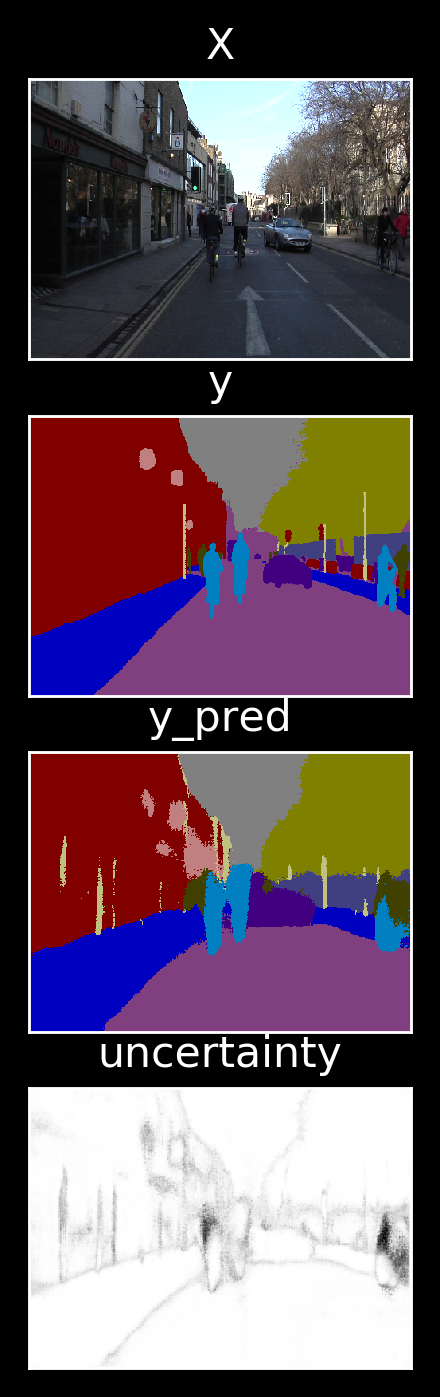

In [22]:
X, y, p, s = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0])

100%|██████████| 50/50 [00:02<00:00, 18.11simulation/s]


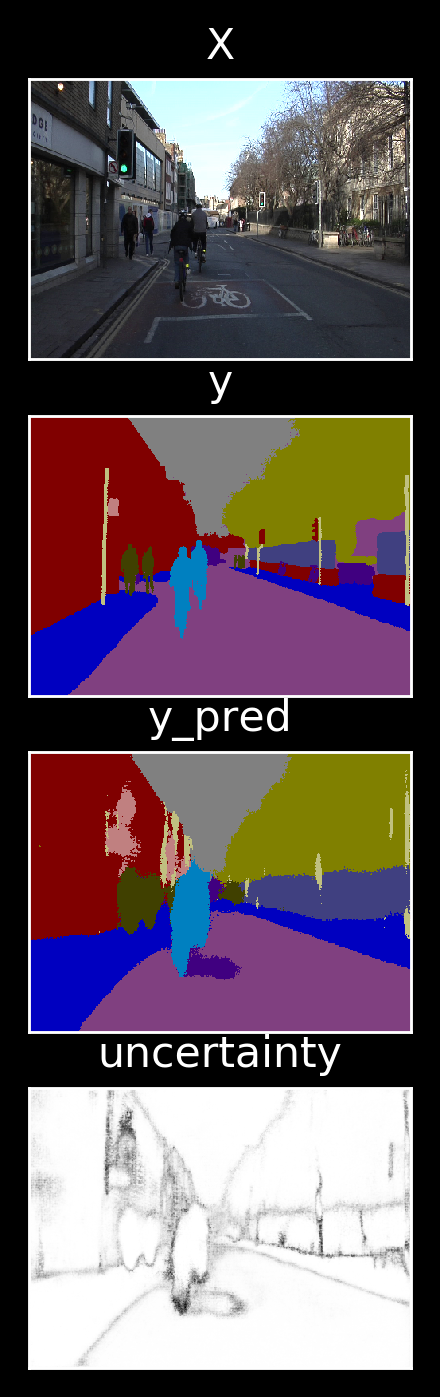

In [23]:
X, y, p, s = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0])

100%|██████████| 50/50 [00:02<00:00, 18.00simulation/s]


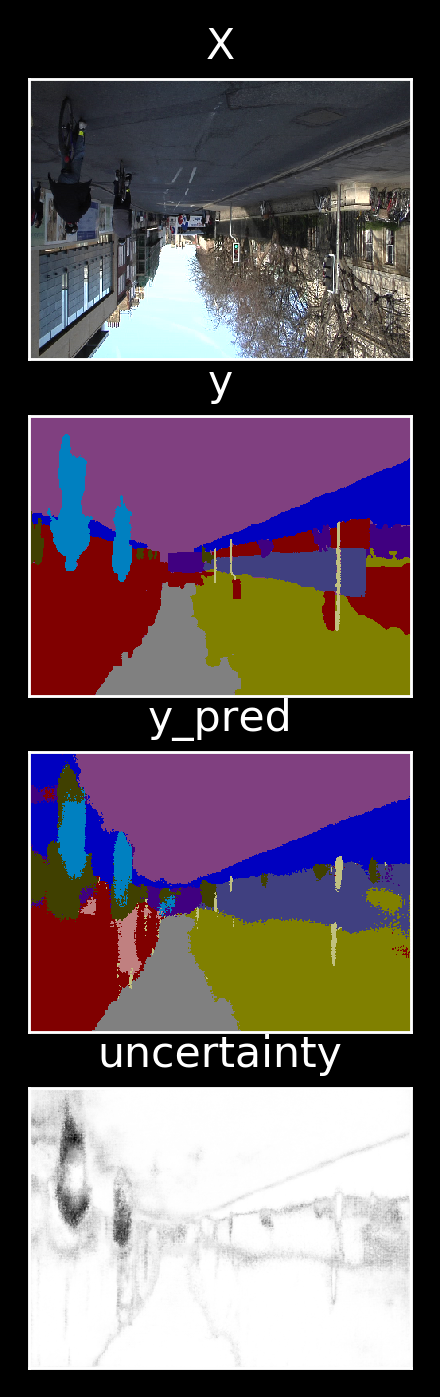

In [24]:
X, y, p, s = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0])

### Test Results

100%|██████████| 50/50 [00:02<00:00, 18.12simulation/s]


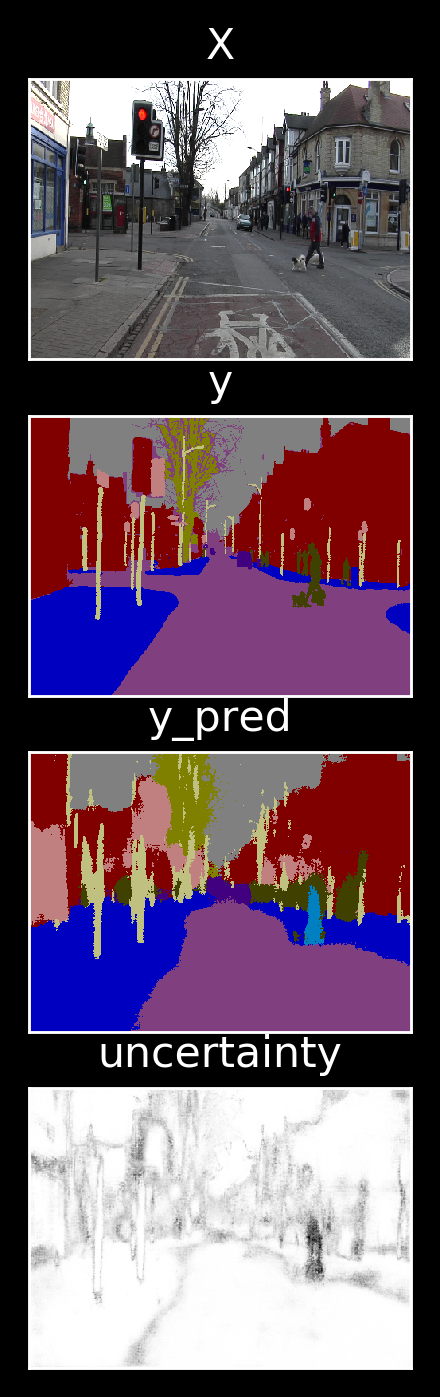

In [25]:
X, y, p, s = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0])

100%|██████████| 50/50 [00:02<00:00, 18.06simulation/s]


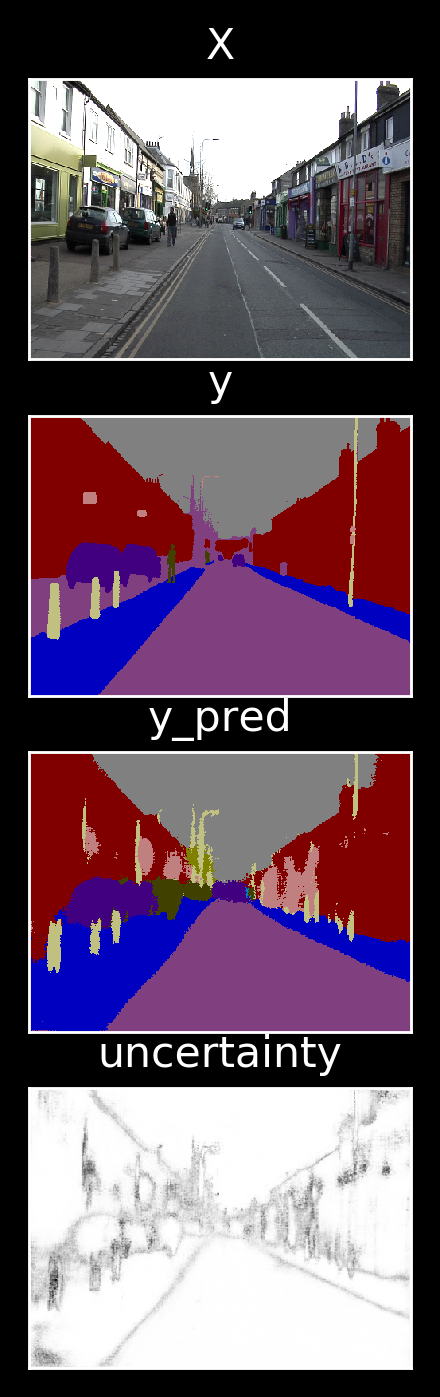

In [26]:
X, y, p, s = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0])

100%|██████████| 50/50 [00:02<00:00, 18.05simulation/s]


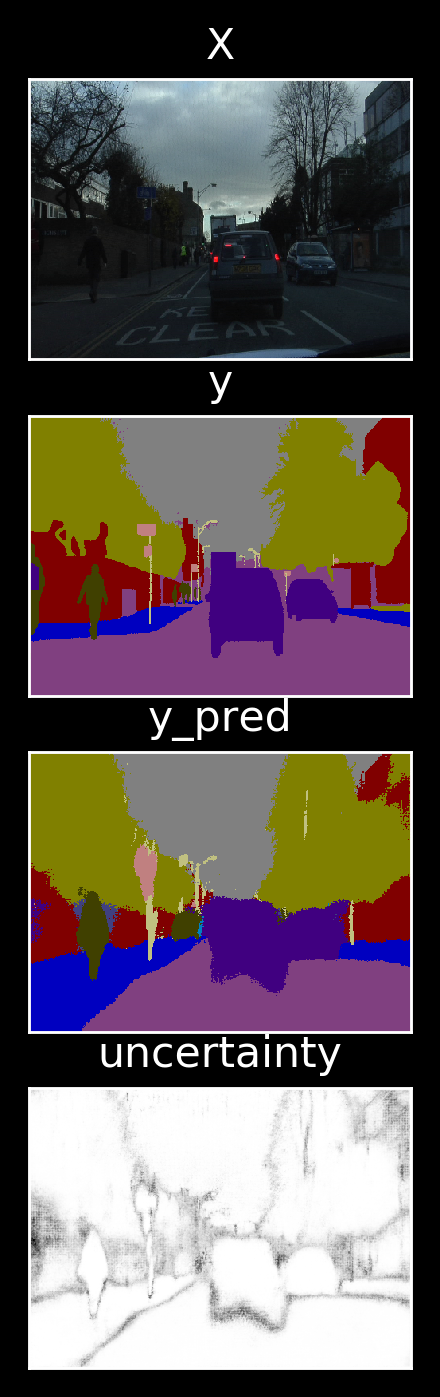

In [27]:
X, y, p, s = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0])

100%|██████████| 50/50 [00:02<00:00, 18.04simulation/s]


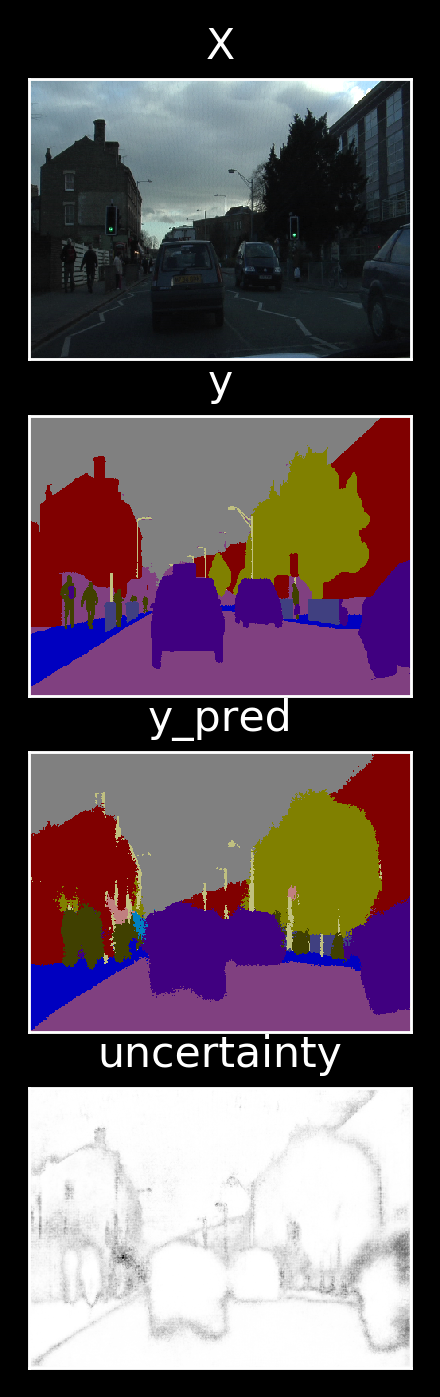

In [28]:
X, y, p, s = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0])